# Purpose of this notebook

This notebook will be to look at a basin by basin breakdown of the volume distribution and see differences between two example years. We will also try to color these in different color scales by the water mass name.

# Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# set the grid, months, mask of interest

In [4]:
# iB = 6
m = 0
s = 1
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
mask = (mymsk < 5) | (mymsk==6) 

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# Read the files

We need:
- theta and salt
- volume from the grid and ETAN

In [5]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2006"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])
# times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [6]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [7]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [8]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


# create the TS bins

In [10]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [11]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [12]:
# Flatten the arrays to use np.add.at
flat_binned_salinity = binned_salinity[:,0,:,:].flatten()
flat_binned_salinity[np.isnan(flat_binned_salinity)] = 0
flat_binned_salinity = flat_binned_salinity.astype(int)

# loop through, look at basin by basin TS distribution

['CanadaB' 'ChukchiS' 'MakarovB' 'AmundsenB' 'NansenB' 'BeringS'
 'BarentsS']


(400.0, 860.0)

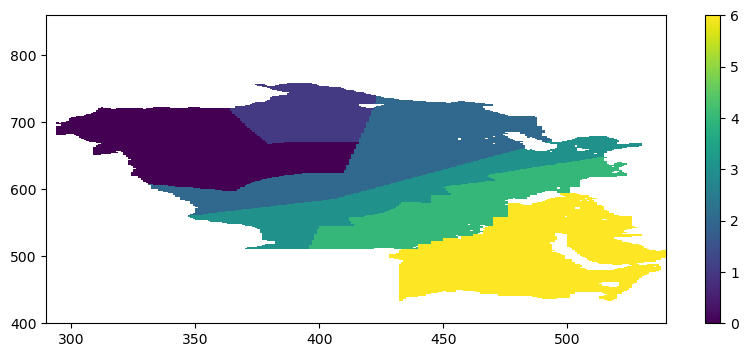

In [13]:
print(strb[0:7])
plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0] * get_aste_tracer(mymsk,nfx,nfy)[0])
maskArc = mskBasin * mymsk
plt.colorbar()
plt.xlim(290,540)
plt.ylim(400,860)

In [14]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
# cmap = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [15]:
def create_TS_mesh(tsstr,nS,nT,npoints, binned_salinity, binned_theta, attr,idxs):
    '''
    returns an nS by nT shaped array with the summed values within the attr (like volume)
    '''
    
    mesh = np.zeros((len(tsstr),nS, nT, npoints))
    tn = 0
    for t in range(len(tsstr)):
        if len(attr.shape) == 4:
            # time x nz x ny x nx
            thisvol = attr[t][:,idxs[0],idxs[1]]
            thissalt = binned_salinity[t][:,idxs[0],idxs[1]]
            thistemp = binned_theta[t][:,idxs[0],idxs[1]]
        elif len(attr.shape) == 3:
            # time x ny x nx
            thisvol = attr[t][maskArc == iB]
            thissalt = binned_salinity[t][idxs[0],idxs[1]]
            thistemp = binned_theta[t][idxs[0],idxs[1]]
            
        # trim the nan values
        thisvol = np.where(np.isnan(thisvol), 0, thisvol)
        thissalt = np.where(np.isnan(thissalt), -1, thissalt)  # Replace NaN with -1
        thistemp = np.where(np.isnan(thistemp), -1, thistemp)
        
        # create the mesh
        meshx = np.zeros((nS,nT,npoints))
        
        # create local timed mesh
        np.add.at(meshx, (thissalt.astype(int), thistemp.astype(int), np.arange(0,npoints,1)), thisvol[...])  # this should work to add at bins
        meshx /= dT   # m^3/deg C
        meshx /= dS   # m^3/deg C/PSU
        
        # add to big mesh
        mesh[tn,:,:,:] = meshx
        del meshx

        tn += 1
    return mesh

In [ ]:
# loop to make all the TS distributions

for iB in range(7):
    print(iB)
    idxs = np.where(maskArc == iB)
    npoints = len(idxs[0])
    mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs)
    
    # try to plot an example
    fig = plt.figure(figsize=(10,5))

    # March
    ax = plt.subplot(121)
    cb = ax.pcolormesh(Sbin,Tbin,np.nansum(mesh[m],axis=2),cmap=cmap,vmin = .001)
    plt.colorbar(cb,label="m^3")
    ax.set_title("Volume Distribution " + datetimes[m].strftime("%Y-%m"))
    ax.set_xlim(25,36)
    ax.set_ylim(-2,9)
    ax.grid()

    # September
    ax = plt.subplot(122)
    cb = ax.pcolormesh(Sbin,Tbin,np.nansum(mesh[s],axis=2),cmap=cmap,vmin = .001)
    plt.colorbar(cb,label="m^3")
    ax.set_title("Volume Distribution " + datetimes[s].strftime("%Y-%m"))
    ax.set_xlim(25,36)
    ax.set_ylim(-2,9)
    ax.grid()

    plt.suptitle(strb[iB])

    plt.savefig(path + strb[iB] + "_TS_distr.png",dpi=300)

# Now see if we can make a big TS distribution and show water mass

In [16]:
idxs = np.where(mymsk == 1)
idxs[0].shape

npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs)

/tmp/ipykernel_298691/317819875.py:6: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.nansum(mesh[m],axis=2))


KeyboardInterrupt: 

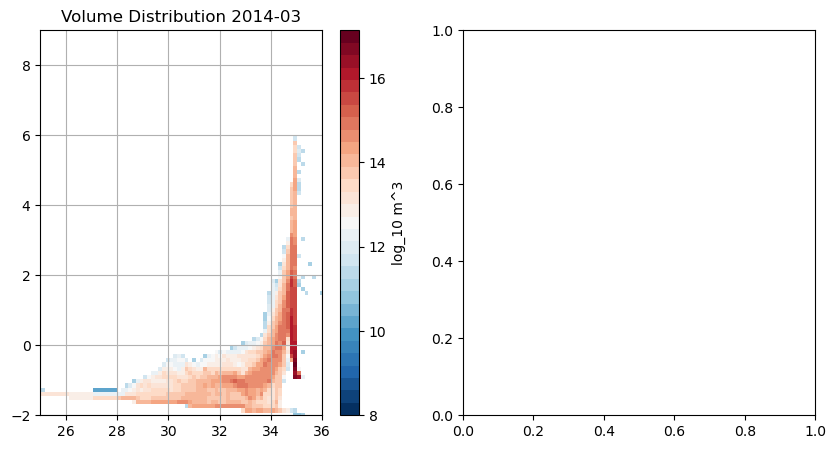

In [17]:
# try to plot an example
fig = plt.figure(figsize=(10,5))

# March
ax = plt.subplot(121)
data = np.log10(np.nansum(mesh[m],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data,cmap=cmap,vmin = 8)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution " + datetimes[m].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# September
ax = plt.subplot(122)
data = np.log10(np.nansum(mesh[s],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data,cmap=cmap,vmin = 8)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution " + datetimes[s].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

plt.suptitle("All Arctic")
plt.savefig(path + "allarctic_TS_distr.png",dpi=300)

In [ ]:
# only surface layer
idxs = np.where(mymsk == 1)
idxs[0].shape

npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[:,2:], binned_theta[:,2:],vol[:,2:],idxs)

In [ ]:
# try the same without the surface layer
# try to plot an example
fig = plt.figure(figsize=(10,5))

# March
ax = plt.subplot(121)
data = np.log10(np.nansum(mesh[m],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data,cmap=cmap,vmin = 8)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution " + datetimes[m].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# September
ax = plt.subplot(122)
data = np.log10(np.nansum(mesh[s],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data,cmap=cmap,vmin = 8)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution " + datetimes[s].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

plt.suptitle("All Arctic")
plt.savefig(path + "allarctic_TS_distr_subsurface.png",dpi=300)

# maybe let's look at the annual average of theta and salt before binning

In [ ]:
# do time averaging of theta and salt first, then recreate binning arrays
theta_avg = np.nanmean(theta,axis=0)
theta_avg.shape
salt_avg = np.nanmean(salt,axis=0)
salt_avg.shape

In [ ]:
vol_avg = np.nanmean(vol,axis=0)

In [ ]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta_avg,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt_avg,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [ ]:
idxs = np.where(mymsk == 1)
idxs[0].shape

npoints = len(idxs[0])
mesh = create_TS_mesh(np.array([tsstr[0]]),nS,nT,npoints,binned_salinity[np.newaxis,:,:,:], binned_theta[np.newaxis,:,:,:],vol_avg[np.newaxis,:,:,:],idxs)

In [ ]:
# try the same without the surface layer
# try to plot an example
fig = plt.figure(figsize=(5,5))

# time mean
ax = plt.subplot(111)
data = np.log10(np.nansum(mesh[0],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data,cmap=cmap,vmin = 8)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution")
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

plt.suptitle("All Arctic Time-Mean")
# plt.savefig(path + "allarctic_TS_distr_timeavg_2006.png",dpi=300)

In [ ]:
# set the indices for some water masses
AWs = np.argmax(binsSLT_centers >= 33)
AWt = np.argmax(binsTH_centers >= 0)

mask = (binsSLT_centers > 31.6) & (binsSLT_centers <= 33)
PWs = np.where(mask)[0]
PWt = np.argmax(binsTH_centers  >= 0)

MWs = np.argmin(binsSLT_centers <= 31.6)

os = np.argmax(binsSLT_centers > 31.6)
ot = np.argmin(binsTH_centers <= 0)

# set separate colormaps
AW_data = data.copy()
AW_data[:AWs] = np.nan
AW_data[:,:AWt] = np.nan

PW_data = data.copy()
PW_data[:PWs[0]] = np.nan
PW_data[PWs[-1]+1:] = np.nan
PW_data[:,:PWt] = np.nan

MW_data = data.copy()
MW_data[MWs:] = np.nan

o_data = data.copy()
o_data[:os] = np.nan
o_data[:,ot:] = np.nan

# plot it up
AWcb = plt.pcolormesh(Sbin,Tbin,AW_data,cmap='Reds',vmin = 10)
PWcb = plt.pcolormesh(Sbin,Tbin,PW_data,cmap='Greens',vmin = 10)
MWcb = plt.pcolormesh(Sbin,Tbin,MW_data,cmap='Blues',vmin = 10)
ocb = plt.pcolormesh(Sbin,Tbin,o_data,cmap='rainbow')
plt.colorbar(AWcb)
plt.colorbar(PWcb)
plt.colorbar(MWcb)
plt.colorbar(ocb)
plt.grid()
plt.xlim(25,36)
plt.ylim(-2,8)

# Let's look closer at the halocline layer for these

In [ ]:
# do time averaging of theta and salt first, then recreate binning arrays
theta_avg_t1 = np.nanmean(theta[:12],axis=0)
salt_avg_t1 = np.nanmean(salt[:12],axis=0)
theta_avg_t2 = np.nanmean(theta[12:],axis=0)
salt_avg_t2 = np.nanmean(salt[12:],axis=0)

In [ ]:
vol_avg_t1 = np.nanmean(vol[:12],axis=0)
vol_avg_t2 = np.nanmean(vol[12:],axis=0)

In [ ]:
# we want to bin theta and salt into the T and S bins
binned_theta_t1 = bin_array(theta_avg_t1,binsTH_edges)
binned_theta_t1 = binned_theta_t1.astype(float)
binned_theta_t1[binned_theta_t1 == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity_t1 = bin_array(salt_avg_t1,binsSLT_edges)
binned_salinity_t1 = binned_salinity_t1.astype(float)
binned_salinity_t1[binned_salinity_t1 == nS] = np.nan

In [ ]:
# we want to bin theta and salt into the T and S bins
binned_theta_t2 = bin_array(theta_avg_t2,binsTH_edges)
binned_theta_t2 = binned_theta_t2.astype(float)
binned_theta_t2[binned_theta_t2 == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity_t2 = bin_array(salt_avg_t2,binsSLT_edges)
binned_salinity_t2 = binned_salinity_t2.astype(float)
binned_salinity_t2[binned_salinity_t2 == nS] = np.nan

In [ ]:
# idxs = np.where(mymsk == 1)
idxs = np.where(maskArc == 6)
idxs[0].shape

npoints = len(idxs[0])
mesh_t1 = create_TS_mesh(np.array([tsstr[0]]),nS,nT,npoints,binned_salinity_t1[np.newaxis,:,:,:], binned_theta_t1[np.newaxis,:,:,:],vol_avg_t1[np.newaxis,:,:,:],idxs)

In [ ]:
# idxs = np.where(mymsk == 1)
idxs = np.where(maskArc == 6)
idxs[0].shape

npoints = len(idxs[0])
mesh_t2 = create_TS_mesh(np.array([tsstr[0]]),nS,nT,npoints,binned_salinity_t2[np.newaxis,:,:,:], binned_theta_t2[np.newaxis,:,:,:],vol_avg_t2[np.newaxis,:,:,:],idxs)

In [ ]:
# try the same without the surface layer
# try to plot an example
fig = plt.figure(figsize=(10,5))

# time mean
ax = plt.subplot(121)
data_t1 = np.log10(np.nansum(mesh_t1[0],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data_t1,cmap=cmap,vmin = 10)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution 2006")
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

ax = plt.subplot(122)
data_t2 = np.log10(np.nansum(mesh_t2[0],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data_t2,cmap=cmap,vmin = 10)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution 2014")
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

plt.suptitle("All Arctic Time-Mean")
plt.savefig(path + "BarentsS_TS_distr_timeavg_comparison.png",dpi=300)

In [ ]:
# try the same without the surface layer
# try to plot an example
fig = plt.figure(figsize=(10,5))

# time mean
ax = plt.subplot(121)
data_t1 = np.log10(np.nansum(mesh_t1[0],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data_t1,cmap='rainbow',vmin = 10)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution 2006")
ax.set_xlim(31.6,35.5)
ax.set_ylim(-2,1)
ax.grid()

ax = plt.subplot(122)
data_t2 = np.log10(np.nansum(mesh_t2[0],axis=2))
cb = ax.pcolormesh(Sbin,Tbin,data_t2,cmap='rainbow',vmin = 10)
plt.colorbar(cb,label="log_10 m^3")
ax.set_title("Volume Distribution 2014")
ax.set_xlim(31.6,35.5)
ax.set_ylim(-2,1)
ax.grid()

plt.suptitle("All Arctic Time-Mean")
plt.savefig(path + "BarentsS_TS_distr_timeavg_HL.png",dpi=300)

# show the arrows based on a specific Basin

In [17]:
iB = 6
print(strb[iB])

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs)
mydata_test_m1 = np.nansum(mesh[m],axis=2)
mydata_test_m2 = np.nansum(mesh[s],axis=2)

# make a mask for iB so we can multiply the advective terms
mymsk_iB = mskBasin.copy()

# Create a boolean mask for elements iB
mask = (mymsk_iB==6) 

# Set non iB elements to nan
mymsk_iB[mask] = 1
mymsk_iB[~mask] = np.nan
mymsk_iB = np.tile(mymsk_iB,(50,1,1))

BarentsS


In [18]:
# grab the advective terms and multiply by mymsk_iB
ADVx_TH_iB = ADVx_TH * mymsk_iB[np.newaxis,:,:,:]
ADVx_SLT_iB = ADVx_SLT * mymsk_iB[np.newaxis,:,:,:]
binned_theta_iB = binned_theta * mymsk_iB[np.newaxis,:,:,:]
binned_salinity_iB = binned_salinity * mymsk_iB[np.newaxis,:,:,:]

In [19]:
# bin these as per the values in the binnedsalt and theta
distrADVx_TH = np.full((len(tsstr),nT,nS),0.0)
distrADVx_SLT = np.full((len(tsstr),nT,nS),0.0)

# for each time step
for t in range(len(tsstr)):
    print(t)

    # grab the advection in each x,y,z point -- maybe fix later to speed things up?
    data_TH = ADVx_TH_iB[t]
    for i in range(data_TH.shape[0]):
        for j in range(data_TH.shape[1]):
            for k in range(data_TH.shape[2]):
                if not np.isnan(binned_theta_iB[t][i,j,k]):
                    distrADVx_TH[t,int(binned_salinity_iB[t][i,j,k]),int(binned_theta_iB[t][i,j,k])] += data_TH[i,j,k]


    data_SLT = ADVx_SLT_iB[t]
    for i in range(data_SLT.shape[0]):
        for j in range(data_SLT.shape[1]):
            for k in range(data_SLT.shape[2]):
                if not np.isnan(binned_salinity_iB[t][i,j,k]):
                    distrADVx_SLT[t,int(binned_salinity_iB[t][i,j,k]),int(binned_theta_iB[t][i,j,k])] += data_SLT[i,j,k]

0
1


In [20]:
# for time saving
a = distrADVx_SLT.copy()
b = distrADVx_TH.copy()

In [39]:
# create the arrows for ADV
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# divide
distrADVx_TH  = distrADVx_TH/binwidthsT_tile[np.newaxis,:,:]/binwidthsS_tile[np.newaxis,:,:]                # m^3/s/PSU
distrADVx_SLT = distrADVx_SLT/binwidthsT_tile[np.newaxis,:,:]/binwidthsS_tile[np.newaxis,:,:]               # m^3/s/degC

distrADVx_TH[distrADVx_TH == 0 ] = np.nan
distrADVx_SLT[distrADVx_SLT == 0 ] = np.nan

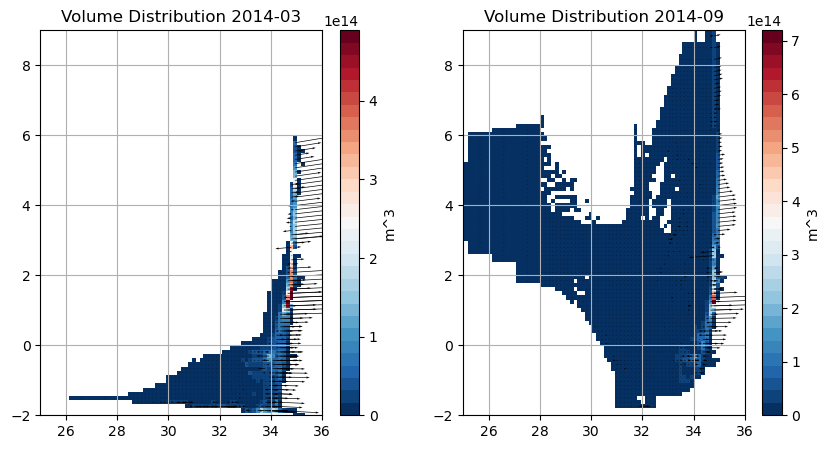

In [42]:
# try to plot an example
fig = plt.figure(figsize=(10,5))

# March
ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,mydata_test_m1,cmap=cmap,vmin = .001)
ax.quiver(Sbincent,Tbincent,distrADVx_SLT[m],distrADVx_TH[m],scale=5e10)    # in units of m^3/s
plt.colorbar(cb,label="m^3")
ax.set_title("Volume Distribution " + datetimes[m].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# September
ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,mydata_test_m2,cmap=cmap,vmin = .001)
ax.quiver(Sbincent,Tbincent,distrADVx_SLT[s],distrADVx_TH[s],scale=5e10)    # in units of m^3/s
plt.colorbar(cb,label="m^3")
ax.set_title("Volume Distribution " + datetimes[s].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# plt.title(strb[iB])

# plt.savefig(path + strb[iB] + "_TS_distr.png",dpi=300)

/tmp/ipykernel_298691/4861626.py:5: RuntimeWarning: Mean of empty slice
  data = np.nanmean(ADVx_SLT[m],axis=0)
/tmp/ipykernel_298691/4861626.py:12: RuntimeWarning: Mean of empty slice
  data = np.nanmean(ADVx_SLT[s],axis=0)


(400.0, 600.0)

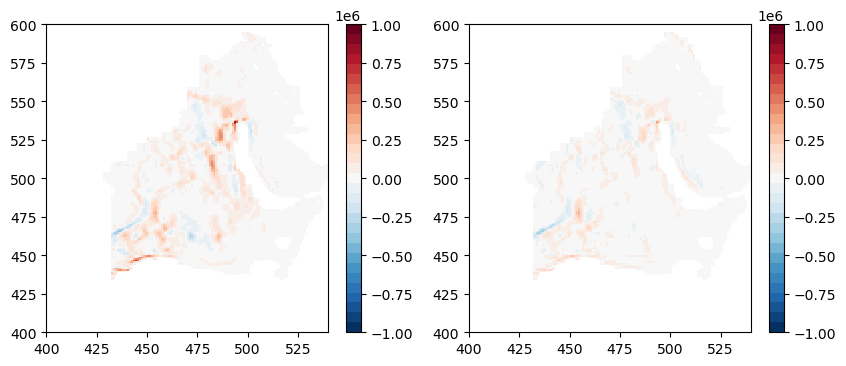

In [46]:
# quickly, does this make sense with the depth-mean advection we see in xyz? Yes!
fig = plt.figure()

ax = plt.subplot(121)
data = np.nanmean(ADVx_SLT[m],axis=0)
cb = ax.pcolormesh(get_aste_tracer(data*mymsk_iB[0],nfx,nfy)[0],cmap=cmap,vmin=-1e6,vmax=1e6)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(122)
data = np.nanmean(ADVx_SLT[s],axis=0)
cb = ax.pcolormesh(get_aste_tracer(data*mymsk_iB[0],nfx,nfy)[0],cmap=cmap,vmin=-1e6,vmax=1e6)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)